Heavily copied from psf_demo_image.py

In [1]:
import sys
from pathlib import Path

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
import betterplotlib as bpl

bpl.set_style()

In [44]:
# ======================================================================================
#
# get the psfs
#
# ======================================================================================
oversampling_factor = 2
psfs = {"quadratic": dict(), "quartic": dict(), "none": dict()}
data_dir = Path(".").resolve().parent / "data"
for galaxy_dir in data_dir.iterdir():
    # store the psf in the dictionary above based on its name
    for psf_type in psfs:
        psf_name = f"psf_{psf_type}_my_stars_15_pixels_2x_oversampled.fits"
        psf_path = galaxy_dir / "size" / psf_name
        psf = fits.open(psf_path)["PRIMARY"].data
        galaxy_name = galaxy_dir.name
        psfs[psf_type][galaxy_name] = psf

In [56]:
# ======================================================================================
#
# Functions to set up the plot
#
# ======================================================================================
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


def bin(bin_size, xs, ys, max_x):
    # then sort them by xs first
    idxs_sort = np.argsort(xs)
    xs = np.array(xs)[idxs_sort]
    ys = np.array(ys)[idxs_sort]

    # then go through and put them in bins
    binned_xs = []
    binned_ys = []
    this_bin_ys = []
    max_bin = bin_size  # start at zero
    for idx in range(len(xs)):
        x = xs[idx]
        y = ys[idx]
        
        if x > max_x:
            break

        # see if we need a new max bin
        if x > max_bin:
            # store our saved data
            if len(this_bin_ys) > 0:
                binned_ys.append(np.mean(this_bin_ys))
                binned_xs.append(max_bin - 0.5 * bin_size)
            # reset the bin
            this_bin_ys = []
            max_bin = np.ceil(x / bin_size) * bin_size

        assert x <= max_bin
        this_bin_ys.append(y)

    return np.array(binned_xs), np.array(binned_ys)


def radial_profile_psf(psf):
    # the center is the central pixel of the image
    x_cen = int((psf.shape[1] - 1.0) / 2.0)
    y_cen = int((psf.shape[0] - 1.0) / 2.0)
    # then go through all the pixel values to determine the distance from the center
    radii = []
    values = []
    for x in range(psf.shape[1]):
        for y in range(psf.shape[1]):
            # need to include the oversampling factor in the distance
            radii.append(distance(x, y, x_cen, y_cen) / oversampling_factor)
            values.append(psf[y][x])

    assert np.isclose(np.sum(values), 1.0)
    # then bin then
    radii, values = bin(0.1, radii, values, 5.5)

    return radii, values

colors = {"none": bpl.color_cycle[3],
          "quartic": bpl.color_cycle[0],
          "quadratic": bpl.color_cycle[2]}
zorders = {"none": 3,
           "quartic": 4,
           "quadratic": 2}

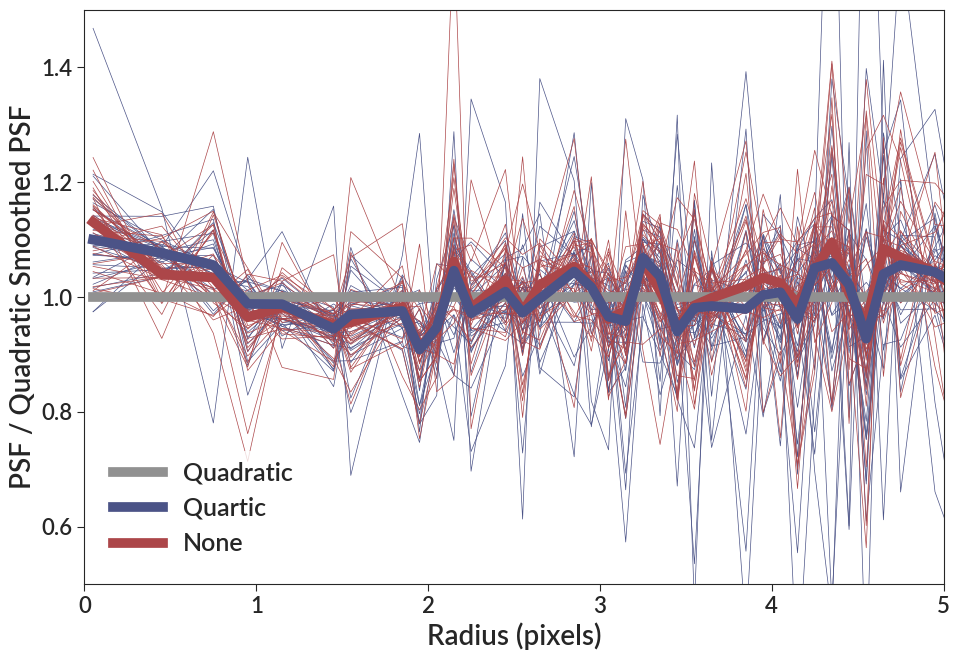

In [59]:
# ======================================================================================
#
# Then the plot itself
#
# ======================================================================================
fig, ax = bpl.subplots()

# show the ratio of the psf to the quadratic one
for psf_type in psfs:
    ratios = []
    plot_radii = None
    for galaxy in psfs[psf_type]:
        psf_reference = psfs["quadratic"][galaxy]
        psf_comparison = psfs[psf_type][galaxy]
        
        # bin both of them then take the ratio
        radii_ref, values_ref = radial_profile_psf(psf_reference)
        radii_cmp, values_cmp = radial_profile_psf(psf_comparison)
        
        assert np.array_equal(radii_ref, radii_cmp)
        ratio = values_cmp / values_ref
        
        # plot this individual line
        ax.plot(radii_ref, ratio, color=colors[psf_type], zorder=1, lw=0.5)
        
        ratios.append(ratio)
        # the x values need to all be the same
        if plot_radii is None:
            plot_radii = radii_ref
        assert np.array_equal(radii_ref, plot_radii)
        
    # calculate the median for each point
    medians = [np.median([profile[idx] for profile in ratios])
               for idx in range(len(ratios[0]))]
    ax.plot(radii_ref, medians, color=colors[psf_type], lw=7, zorder=zorders[psf_type], label=psf_type.title())

ax.add_labels("Radius (pixels)", "PSF / Quadratic Smoothed PSF")
# ax.set_yscale("log")
ax.set_limits(0, 5, 0.5, 1.5)
# ax.xaxis.set_ticks([0, 2, 4, 6, 8, 10])
ax.legend()
fig.savefig("psf_ratios.png")